In [1]:
import sys
sys.path.append('..')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [2]:
import taiko as tk
from taiko.tools.config import *
from taiko.play import get_play, get_similarity
from taiko.database import load_record_df

from itertools import product
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import posixpath
import multiprocessing
from sklearn.preprocessing import StandardScaler

sns.set(font_scale=1.5)

Using TensorFlow backend.


In [3]:
SONG_ID = 1

In [4]:
record_df = load_record_df(song_id=SONG_ID)
record_df

,drummer_name,song_id,left_sensor_datetime,right_sensor_datetime,capture_datetime
1,aaaaa,1,L_2018-09-28_111304.csv,R_2018-09-28_111305.csv,capture_2018_09_28_11_13_05
5,aaaaa,1,L_2018-09-28_112912.csv,R_2018-09-28_112913.csv,capture_2018_09_28_11_29_13
9,aaaaa,1,L_2018-09-28_114340.csv,R_2018-09-28_114340.csv,capture_2018_09_28_11_43_41
13,aaaaa,1,L_2018-09-28_115822.csv,R_2018-09-28_115823.csv,capture_2018_09_28_11_58_23
25,carolyn,1,L_2018-09-27_154913.csv,R_2018-09-27_154916.csv,capture_2018_09_27_15_49_16
29,carolyn,1,L_2018-09-27_160509.csv,R_2018-09-27_160510.csv,capture_2018_09_27_16_05_10
33,carolyn,1,L_2018-09-27_161825.csv,R_2018-09-27_161826.csv,capture_2018_09_27_16_18_26
37,carolyn,1,L_2018-09-27_163110.csv,R_2018-09-27_163111.csv,capture_2018_09_27_16_31_11
42,celiven,1,L_2018-09-22_141822.csv,R_2018-09-22_141821.csv,capture_2018_09_22_14_18_21
46,celiven,1,L_2018-09-22_142958.csv,R_2018-09-22_142957.csv,capture_2018_09_22_14_29_57


In [5]:
play_result_df = pd.read_csv(PLAY_RESULT_TABLE_PATH)
play_result_df.drop(['drummer_name', 'song_id', 'capture_datetime'], axis=1, inplace=True)
play_record_df = record_df.merge(play_result_df, left_index=True, right_on='id', how='inner')
play_record_df['note'] = play_record_df['good'] + play_record_df['ok'] + play_record_df['bad']
play_record_df = play_record_df[play_record_df['note'] == ALL_NOTE_COUNT_DICT[SONG_ID]]
play_record_df.drop('note', axis=1, inplace=True)
play_record_df

,drummer_name,song_id,left_sensor_datetime,right_sensor_datetime,capture_datetime,id,p_order,score,good,ok,bad,max_combo,drumroll
0,aaaaa,1,L_2018-09-28_111304.csv,R_2018-09-28_111305.csv,capture_2018_09_28_11_13_05,1,1,975110,81,5,0,86,78
4,aaaaa,1,L_2018-09-28_112912.csv,R_2018-09-28_112913.csv,capture_2018_09_28_11_29_13,5,2,989360,84,2,0,86,63
8,aaaaa,1,L_2018-09-28_114340.csv,R_2018-09-28_114340.csv,capture_2018_09_28_11_43_41,9,3,979660,84,2,0,86,68
12,aaaaa,1,L_2018-09-28_115822.csv,R_2018-09-28_115823.csv,capture_2018_09_28_11_58_23,13,4,991060,84,2,0,86,74
16,carolyn,1,L_2018-09-27_154913.csv,R_2018-09-27_154916.csv,capture_2018_09_27_15_49_16,25,1,792630,54,30,2,84,42
20,carolyn,1,L_2018-09-27_160509.csv,R_2018-09-27_160510.csv,capture_2018_09_27_16_05_10,29,2,803450,57,25,4,61,48
24,carolyn,1,L_2018-09-27_161825.csv,R_2018-09-27_161826.csv,capture_2018_09_27_16_18_26,33,3,945560,76,10,0,86,49
28,carolyn,1,L_2018-09-27_163110.csv,R_2018-09-27_163111.csv,capture_2018_09_27_16_31_11,37,4,913960,71,15,0,86,47
32,celiven,1,L_2018-09-22_141822.csv,R_2018-09-22_141821.csv,capture_2018_09_22_14_18_21,42,1,978860,82,4,0,86,94
35,celiven,1,L_2018-09-22_142958.csv,R_2018-09-22_142957.csv,capture_2018_09_22_14_29_57,46,2,994710,85,1,0,86,95


In [6]:
full_combo_df = play_record_df[play_record_df['bad'] == 0]
full_combo_df

,drummer_name,song_id,left_sensor_datetime,right_sensor_datetime,capture_datetime,id,p_order,score,good,ok,bad,max_combo,drumroll
0,aaaaa,1,L_2018-09-28_111304.csv,R_2018-09-28_111305.csv,capture_2018_09_28_11_13_05,1,1,975110,81,5,0,86,78
4,aaaaa,1,L_2018-09-28_112912.csv,R_2018-09-28_112913.csv,capture_2018_09_28_11_29_13,5,2,989360,84,2,0,86,63
8,aaaaa,1,L_2018-09-28_114340.csv,R_2018-09-28_114340.csv,capture_2018_09_28_11_43_41,9,3,979660,84,2,0,86,68
12,aaaaa,1,L_2018-09-28_115822.csv,R_2018-09-28_115823.csv,capture_2018_09_28_11_58_23,13,4,991060,84,2,0,86,74
24,carolyn,1,L_2018-09-27_161825.csv,R_2018-09-27_161826.csv,capture_2018_09_27_16_18_26,33,3,945560,76,10,0,86,49
28,carolyn,1,L_2018-09-27_163110.csv,R_2018-09-27_163111.csv,capture_2018_09_27_16_31_11,37,4,913960,71,15,0,86,47
32,celiven,1,L_2018-09-22_141822.csv,R_2018-09-22_141821.csv,capture_2018_09_22_14_18_21,42,1,978860,82,4,0,86,94
35,celiven,1,L_2018-09-22_142958.csv,R_2018-09-22_142957.csv,capture_2018_09_22_14_29_57,46,2,994710,85,1,0,86,95
38,celiven,1,L_2018-09-22_144040.csv,R_2018-09-22_144039.csv,capture_2018_09_22_14_40_39,50,3,989460,84,2,0,86,94
40,celiven,1,L_2018-09-22_145139.csv,R_2018-09-22_145139.csv,capture_2018_09_22_14_51_38,54,4,999560,86,0,0,86,50


In [7]:
# CONSIDERED_IDS = [1, 5, 33, 37, 61, 65, 99, 107, 141, 150, 180, 181, 241, 249, 254, 258, 288, 310, 323, 327]
# CONSIDERED_IDS = [1, 33, 61, 99, 141, 180, 241, 254, 288, 323]
# CONSIDERED_IDS = [10, 14, 52, 56, 79, 83, 121, 125, 155, 159, 208, 216, 280, 284, 311, 315, 350, 354]
CONSIDERED_IDS = full_combo_df['id'].values
CONSIDERED_IDS

array([  1,   5,   9,  13,  33,  37,  42,  46,  50,  54,  61,  65,  69,
        76,  78,  82,  99, 107, 112, 116, 120, 124, 141, 150, 154, 158,
       180, 181, 182, 203, 207, 211, 215, 241, 249, 254, 258, 262, 266,
       271, 275, 279, 283, 288, 310, 314, 318, 323, 327, 331, 335, 341,
       345, 349, 353])

In [8]:
plays = []
with multiprocessing.Pool() as p:
    record_rows = [record_df.loc[id_] for id_ in CONSIDERED_IDS]
    for _, play in tqdm(enumerate(p.imap(get_play, record_rows)), total=len(record_rows)):
        try:
            plays.append(play)
        except Exception:
            pass

play_record_df[play_record_df['id'].isin(CONSIDERED_IDS)]

100%|██████████| 55/55 [02:41<00:00,  2.94s/it]


,drummer_name,song_id,left_sensor_datetime,right_sensor_datetime,capture_datetime,id,p_order,score,good,ok,bad,max_combo,drumroll
0,aaaaa,1,L_2018-09-28_111304.csv,R_2018-09-28_111305.csv,capture_2018_09_28_11_13_05,1,1,975110,81,5,0,86,78
4,aaaaa,1,L_2018-09-28_112912.csv,R_2018-09-28_112913.csv,capture_2018_09_28_11_29_13,5,2,989360,84,2,0,86,63
8,aaaaa,1,L_2018-09-28_114340.csv,R_2018-09-28_114340.csv,capture_2018_09_28_11_43_41,9,3,979660,84,2,0,86,68
12,aaaaa,1,L_2018-09-28_115822.csv,R_2018-09-28_115823.csv,capture_2018_09_28_11_58_23,13,4,991060,84,2,0,86,74
24,carolyn,1,L_2018-09-27_161825.csv,R_2018-09-27_161826.csv,capture_2018_09_27_16_18_26,33,3,945560,76,10,0,86,49
28,carolyn,1,L_2018-09-27_163110.csv,R_2018-09-27_163111.csv,capture_2018_09_27_16_31_11,37,4,913960,71,15,0,86,47
32,celiven,1,L_2018-09-22_141822.csv,R_2018-09-22_141821.csv,capture_2018_09_22_14_18_21,42,1,978860,82,4,0,86,94
35,celiven,1,L_2018-09-22_142958.csv,R_2018-09-22_142957.csv,capture_2018_09_22_14_29_57,46,2,994710,85,1,0,86,95
38,celiven,1,L_2018-09-22_144040.csv,R_2018-09-22_144039.csv,capture_2018_09_22_14_40_39,50,3,989460,84,2,0,86,94
40,celiven,1,L_2018-09-22_145139.csv,R_2018-09-22_145139.csv,capture_2018_09_22_14_51_38,54,4,999560,86,0,0,86,50


In [9]:
similarity_mat = []
with multiprocessing.Pool() as p:
    result = p.starmap(get_similarity, product(plays, repeat=2))
    ids = list(product(CONSIDERED_IDS, repeat=2))
    for ids_, sim in zip(ids, result):
        similarity_mat.append(list(ids_) + list(sim))
#         sim = get_similarity(row1[1], row2[1])
#         similarity_mat.append([row1[0], row2[0], sim[0], sim[1]])
#         print(sim)


similarity_df = pd.DataFrame(data=similarity_mat)
similarity_df.columns = ['a_id', 'b_id', 'acc_dtw', 'gyr_dtw']
similarity_df

,a_id,b_id,acc_dtw,gyr_dtw
0,1,1,0.000000,0.000000e+00
1,1,5,40332.124818,5.138353e+05
2,1,9,32534.989130,4.793884e+05
3,1,13,40796.256355,6.209323e+05
4,1,33,46356.610303,6.888097e+05
5,1,37,46889.044283,6.921207e+05
6,1,42,57362.621524,8.459446e+05
7,1,46,54118.779317,7.940805e+05
8,1,50,54662.873269,8.970416e+05
9,1,54,54293.566577,8.590840e+05


In [26]:
scaler = StandardScaler()

dtw_df = similarity_df.copy()
dtw_df['same'] = (dtw_df['a_id'] == dtw_df['b_id'])
dtw_df = dtw_df[~dtw_df['same']].drop('same', axis=1)
dtw_df[['acc_dtw', 'gyr_dtw']] = scaler.fit_transform(dtw_df[['acc_dtw', 'gyr_dtw']])
# dtw_df['acc_dtw'] -= dtw_df.min(axis=0)['acc_dtw']
# dtw_df['gyr_dtw'] -= dtw_df.min(axis=0)['gyr_dtw']
dtw_df['norm_dtw'] = (dtw_df['acc_dtw'] + dtw_df['gyr_dtw']) / 2
dtw_df

,a_id,b_id,acc_dtw,gyr_dtw,norm_dtw
1,1,5,-0.219858,-0.730935,-0.475397
2,1,9,-0.841300,-0.912364,-0.876832
3,1,13,-0.182866,-0.166867,-0.174867
4,1,33,0.260301,0.190636,0.225469
5,1,37,0.302737,0.208075,0.255406
6,1,42,1.137495,1.018249,1.077872
7,1,46,0.878957,0.745086,0.812021
8,1,50,0.922322,1.287371,1.104847
9,1,54,0.892887,1.087453,0.990170
10,1,61,0.080968,-0.047520,0.016724


In [27]:
vis_right_df = play_record_df.copy()
vis_right_df = vis_right_df[['drummer_name', 'id']]

dtw_df = dtw_df.merge(vis_right_df, left_on='a_id', right_on='id', how='inner')
dtw_df = dtw_df.merge(vis_right_df, left_on='b_id', right_on='id', how='inner')
dtw_df.drop(['id_x', 'id_y'], axis=1, inplace=True)
dtw_df = dtw_df.rename(index=str, columns={'drummer_name_x': 'a_drummer_name',
                                  'drummer_name_y': 'b_drummer_name'})
dtw_df['a_id'] = dtw_df['a_id'].apply(str)
dtw_df['b_id'] = dtw_df['b_id'].apply(str)
dtw_df['play1'] = dtw_df[['a_drummer_name', 'a_id']].apply(lambda x: '-'.join(x), axis=1)
dtw_df['play2'] = dtw_df[['b_drummer_name', 'b_id']].apply(lambda x: '-'.join(x), axis=1)

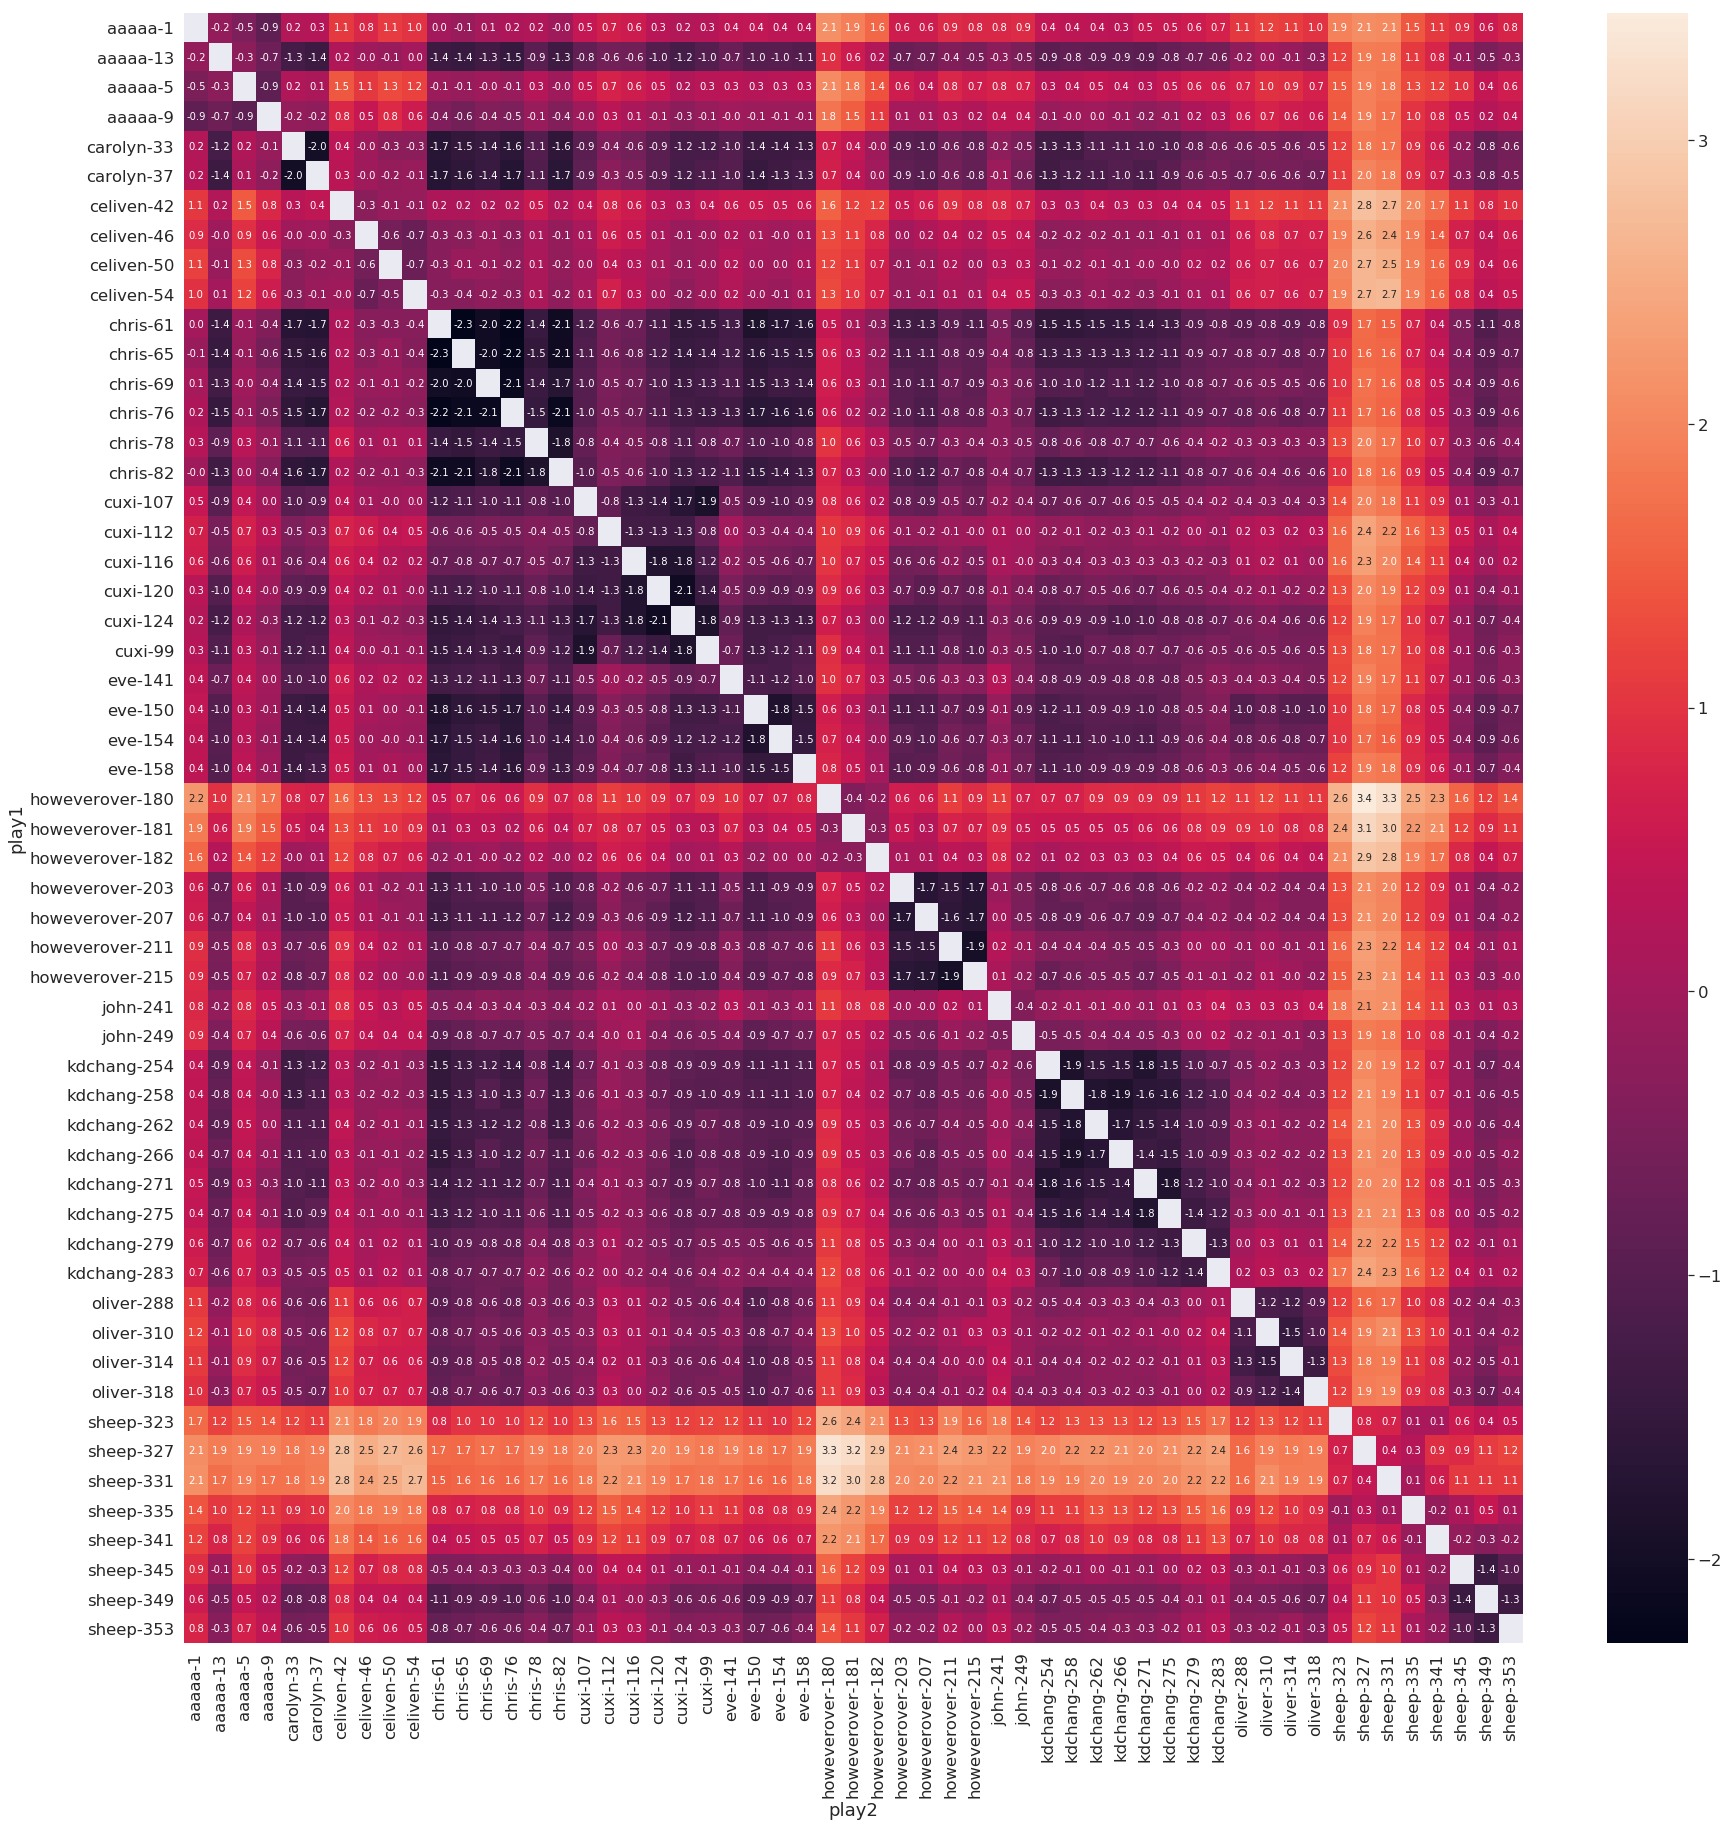

In [28]:
vis_df = dtw_df.pivot('play1', 'play2', 'norm_dtw')
plt.figure(figsize=(30, 30))
ax = sns.heatmap(vis_df, annot=True, fmt='.1f')